<a href="https://colab.research.google.com/github/KCSarkar123/Machine-Learning-Lab-Assignments-/blob/main/ML_Ass1_Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Assignment-1**
 (Naive Bayes & Decision Tree on Breast Cancer)
# Name : Krishna Chandra Sarkar
# Roll : 002211001050

---




This notebook builds and evaluates multiple classifiers on two UCI datasets using **scikit-learn**:
- Naive Bayes: **GaussianNB**, **MultinomialNB**, **BernoulliNB**
- **DecisionTreeClassifier** (both *gini* and *entropy*)

It reports **Accuracy, Precision, Recall, F1-score** and **Confusion Matrix**, then saves **decision tree images** (with impurity shown) for both criteria.

> Tip: Run all cells top-to-bottom. Outputs (images, CSV) are written to the `outputs/` folder.

In [1]:

import os, itertools, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)

In [2]:

def plot_confusion(cm, classes, title, save_path=None):
    fig, ax = plt.subplots(figsize=(5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes, title=title, ylabel='True', xlabel='Predicted')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center")
    fig.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

def compute_metrics(y_true, y_pred, average='weighted'):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=0)
    return acc, prec, rec, f1

In [3]:

#iris = datasets.load_iris()
bc = datasets.load_breast_cancer()

datasets_map = {
    #"Iris": (iris.data, iris.target, iris.feature_names, iris.target_names),
    "BreastCancer": (bc.data, bc.target, bc.feature_names, bc.target_names),
}

# Train/test split for each dataset (stratified)
splits = {}
for name, (X, y, feat_names, class_names) in datasets_map.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
    )
    splits[name] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test,
        "feature_names": feat_names, "class_names": class_names
    }
print("Datasets prepared:", list(splits.keys()))

Datasets prepared: ['BreastCancer']



[BreastCancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9298 | Precision: 0.9298 | Recall: 0.9298 | F1: 0.9298
              precision    recall  f1-score   support

   malignant       0.90      0.90      0.90        42
      benign       0.94      0.94      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114



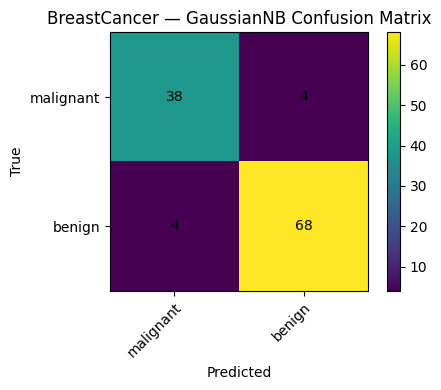


[BreastCancer] Tuning MultinomialNB ...
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}
Test Accuracy: 0.8596 | Precision: 0.8852 | Recall: 0.8596 | F1: 0.8502
              precision    recall  f1-score   support

   malignant       1.00      0.62      0.76        42
      benign       0.82      1.00      0.90        72

    accuracy                           0.86       114
   macro avg       0.91      0.81      0.83       114
weighted avg       0.89      0.86      0.85       114



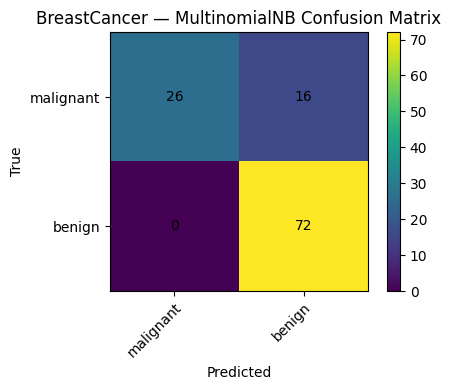


[BreastCancer] Tuning BernoulliNB ...
Best params: {'clf__alpha': 0.5, 'clf__binarize': 0.3}
Test Accuracy: 0.9211 | Precision: 0.9234 | Recall: 0.9211 | F1: 0.9216
              precision    recall  f1-score   support

   malignant       0.87      0.93      0.90        42
      benign       0.96      0.92      0.94        72

    accuracy                           0.92       114
   macro avg       0.91      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114



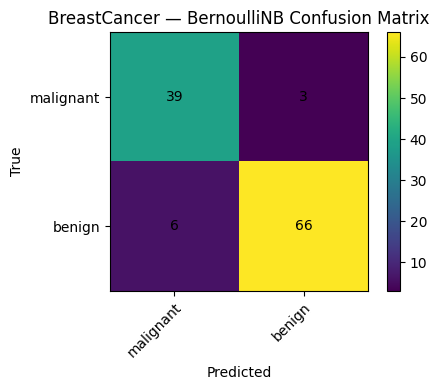


Saved NB summary to: outputs/naive_bayes_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1
0,BreastCancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.929825,0.929825,0.929825,0.929825
1,BreastCancer,MultinomialNB,"{'clf__alpha': 0.1, 'clf__fit_prior': True}",0.859649,0.885167,0.859649,0.850155
2,BreastCancer,BernoulliNB,"{'clf__alpha': 0.5, 'clf__binarize': 0.3}",0.921053,0.923417,0.921053,0.921574


In [4]:


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

def run_nb_models(dataset_name, split, outdir):
    results = []
    # 1) GaussianNB (works fine on real-valued features)
    gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
    gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}

    # 2) MultinomialNB (expects non-negative features) -> MinMax scale
    mnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
    mnb_grid = {'clf__alpha': [0.1, 0.5, 1.0, 1.5], 'clf__fit_prior': [True, False]}

    # 3) BernoulliNB (best with binary features) -> scale then use clf's binarize
    bnb_pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', BernoulliNB())])
    bnb_grid = {'clf__alpha': [0.1, 0.5, 1.0], 'clf__binarize': [0.1, 0.2, 0.3, 0.4, 0.5]}

    configs = [
        ("GaussianNB", gnb_pipe, gnb_grid),
        ("MultinomialNB", mnb_pipe, mnb_grid),
        ("BernoulliNB", bnb_pipe, bnb_grid),
    ]

    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    class_names = split["class_names"]

    for name, pipe, grid in configs:
        print(f"\n[{dataset_name}] Tuning {name} ...")
        gs = GridSearchCV(pipe, grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))
        cm = confusion_matrix(y_test, y_pred)
        ensure_dir(outdir)
        cm_path = os.path.join(outdir, f"{dataset_name}_{name}_confusion.png")
        plot_confusion(cm, class_names, f"{dataset_name} — {name} Confusion Matrix", save_path=cm_path)
        results.append({
            "dataset": dataset_name, "model": name, "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(results)

all_nb_results = []

for dname, split in splits.items():
    outdir = os.path.join(OUT_DIR, dname, "NB")
    df = run_nb_models(dname, split, outdir)
    all_nb_results.append(df)

nb_results = pd.concat(all_nb_results, ignore_index=True)
nb_csv_path = os.path.join(OUT_DIR, "naive_bayes_results.csv")
nb_results.to_csv(nb_csv_path, index=False)
print("\nSaved NB summary to:", nb_csv_path)
nb_results

[BreastCancer] DecisionTree (gini) best params: {'clf__class_weight': None, 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__splitter': 'random'}
Test Accuracy: 0.9211 | Precision: 0.9234 | Recall: 0.9211 | F1: 0.9216


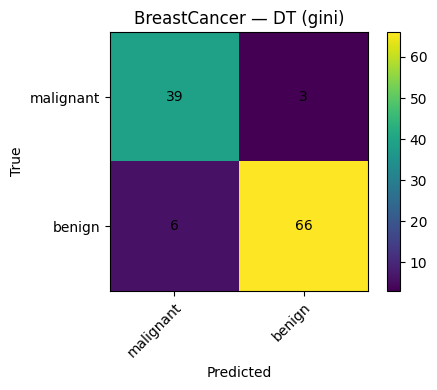

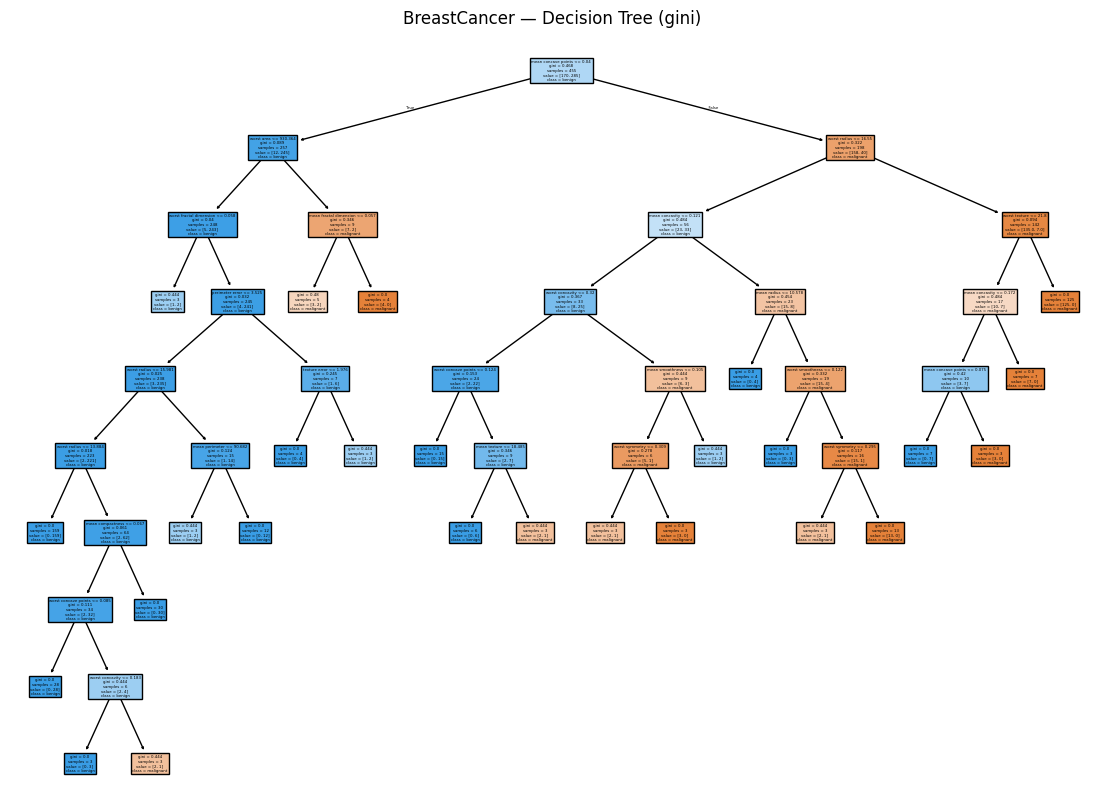

[BreastCancer] DecisionTree (entropy) best params: {'clf__class_weight': None, 'clf__criterion': 'entropy', 'clf__max_depth': 6, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 2, 'clf__splitter': 'random'}
Test Accuracy: 0.9474 | Precision: 0.9474 | Recall: 0.9474 | F1: 0.9474


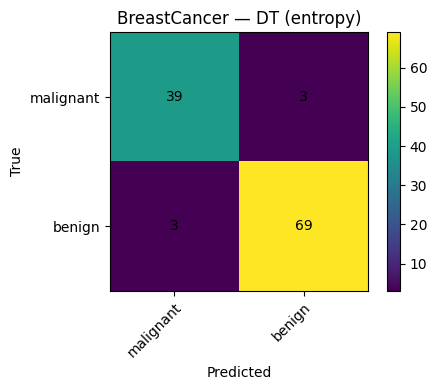

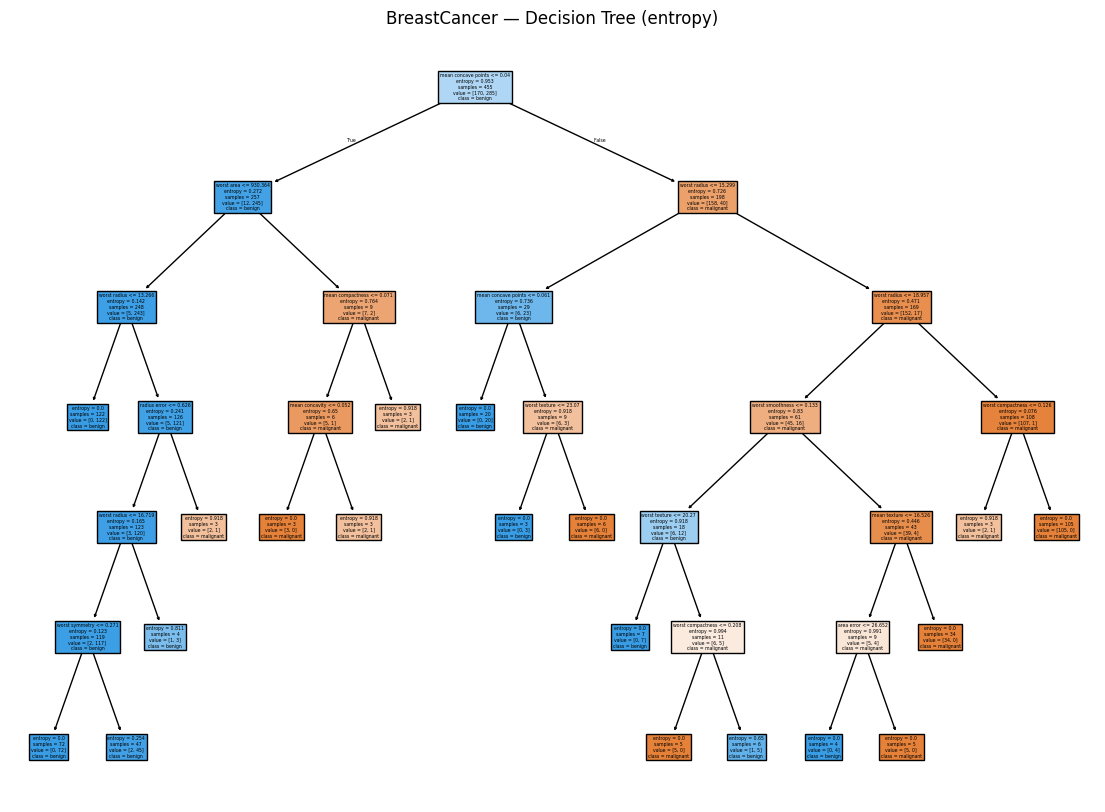


Saved Decision Tree summary to: outputs/decision_tree_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1,tree_image
0,BreastCancer,DecisionTree-gini,"{'clf__class_weight': None, 'clf__criterion': ...",0.921053,0.923417,0.921053,0.921574,outputs/BreastCancer/DecisionTree/Gini/BreastC...
1,BreastCancer,DecisionTree-entropy,"{'clf__class_weight': None, 'clf__criterion': ...",0.947368,0.947368,0.947368,0.947368,outputs/BreastCancer/DecisionTree/Entropy/Brea...


In [5]:


def fit_dt_for_criterion(dataset_name, split, criterion, base_outdir):
    X_train, X_test = split["X_train"], split["X_test"]
    y_train, y_test = split["y_train"], split["y_test"]
    feat_names = split["feature_names"]
    class_names = split["class_names"]

    pipe = Pipeline([('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])
    grid = {
        'clf__criterion': [criterion],
        'clf__max_depth': [None, 3, 4, 5, 6, 8, 10],
        'clf__min_samples_split': [2, 4, 6, 8, 10],
        'clf__min_samples_leaf': [1, 2, 3, 4],
        'clf__class_weight': [None, 'balanced'],
        'clf__splitter': ['best', 'random']
    }
    gs = GridSearchCV(pipe, grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                      n_jobs=-1, scoring='accuracy', refit=True)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_['clf']
    y_pred = gs.predict(X_test)
    acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
    print(f"[{dataset_name}] DecisionTree ({criterion}) best params:", gs.best_params_)
    print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")


    cm = confusion_matrix(y_test, y_pred)
    outdir = os.path.join(base_outdir, criterion.capitalize())
    ensure_dir(outdir)
    cm_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_confusion.png")
    plot_confusion(cm, class_names, f"{dataset_name} — DT ({criterion})", save_path=cm_path)


    fig, ax = plt.subplots(figsize=(14, 10))
    plot_tree(best_clf, feature_names=feat_names, class_names=class_names, filled=True, impurity=True)
    ax.set_title(f"{dataset_name} — Decision Tree ({criterion})")
    tree_img_path = os.path.join(outdir, f"{dataset_name}_DT_{criterion}_tree.png")
    plt.savefig(tree_img_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    return {
        "dataset": dataset_name, "model": f"DecisionTree-{criterion}",
        "best_params": gs.best_params_, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
        "tree_image": tree_img_path
    }

dt_rows = []
for dname, split in splits.items():
    base_out = os.path.join(OUT_DIR, dname, "DecisionTree")
    ensure_dir(base_out)
    for crit in ["gini", "entropy"]:
        row = fit_dt_for_criterion(dname, split, crit, base_out)
        dt_rows.append(row)

dt_results = pd.DataFrame(dt_rows)
dt_csv_path = os.path.join(OUT_DIR, "decision_tree_results.csv")
dt_results.to_csv(dt_csv_path, index=False)
print("\nSaved Decision Tree summary to:", dt_csv_path)
dt_results


=== Train/Test Split: 60-40 ===
BreastCancer → Train: 341, Test: 228

[BreastCancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9342 | Precision: 0.9343 | Recall: 0.9342 | F1: 0.9338

=== Train/Test Split: 50-50 ===
BreastCancer → Train: 284, Test: 285

[BreastCancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9368 | Precision: 0.9374 | Recall: 0.9368 | F1: 0.9363

=== Train/Test Split: 30-70 ===
BreastCancer → Train: 170, Test: 399

[BreastCancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9248 | Precision: 0.9249 | Recall: 0.9248 | F1: 0.9242

=== Train/Test Split: 80-20 ===
BreastCancer → Train: 455, Test: 114

[BreastCancer] Tuning GaussianNB ...
Best params: {'clf__var_smoothing': 1e-09}
Test Accuracy: 0.9298 | Precision: 0.9298 | Recall: 0.9298 | F1: 0.9298


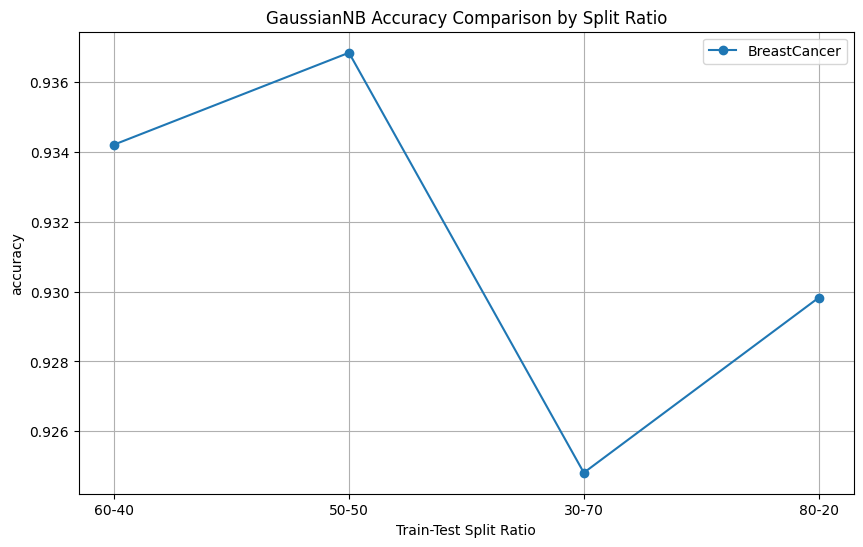

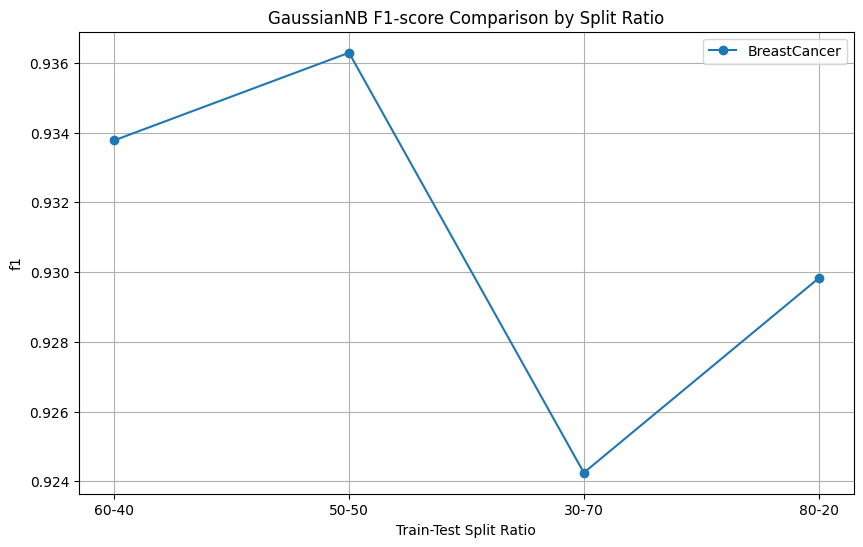


Saved GaussianNB split results to: outputs/gaussiannb_split_results.csv


,dataset,model,best_params,accuracy,precision,recall,f1,split_ratio
0,BreastCancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.934211,0.934322,0.934211,0.933779,60-40
1,BreastCancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.936842,0.937361,0.936842,0.936294,50-50
2,BreastCancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.924812,0.924937,0.924812,0.924244,30-70
3,BreastCancer,GaussianNB,{'clf__var_smoothing': 1e-09},0.929825,0.929825,0.929825,0.929825,80-20


In [6]:


split_ratios = [0.4, 0.5, 0.7, 0.2] # Corresponds to test sizes for 60-40, 50-50, 30-70, 80-20 splits

nb_split_results = []

for ratio in split_ratios:
    print(f"\n=== Train/Test Split: {int((1-ratio)*100)}-{int(ratio*100)} ===")
    for name, (X, y, feat_names, class_names) in datasets_map.items():
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=ratio, stratify=y, random_state=RANDOM_STATE
        )
        print(f"{name} → Train: {len(X_train)}, Test: {len(X_test)}")

        # Run GaussianNB
        gnb_pipe = Pipeline([('scaler', StandardScaler()), ('clf', GaussianNB())])
        gnb_grid = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]}
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

        print(f"\n[{name}] Tuning GaussianNB ...")
        gs = GridSearchCV(gnb_pipe, gnb_grid, cv=cv, n_jobs=-1, scoring='accuracy', refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc, prec, rec, f1 = compute_metrics(y_test, y_pred)
        print(f"Best params: {gs.best_params_}")
        print(f"Test Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

        nb_split_results.append({
            "dataset": name, "model": "GaussianNB", "best_params": gs.best_params_,
            "accuracy": acc, "precision": prec, "recall": rec, "f1": f1,
            "split_ratio": f"{int((1-ratio)*100)}-{int(ratio*100)}"
        })

nb_split_results_df = pd.DataFrame(nb_split_results)


def plot_nb_comparison_chart(df, metric, title):
    plt.figure(figsize=(10, 6))
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        plt.plot(dataset_data['split_ratio'], dataset_data[metric], marker='o', label=dataset)

    plt.title(title)
    plt.xlabel('Train-Test Split Ratio')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_nb_comparison_chart(nb_split_results_df, 'accuracy', 'GaussianNB Accuracy Comparison by Split Ratio')
plot_nb_comparison_chart(nb_split_results_df, 'f1', 'GaussianNB F1-score Comparison by Split Ratio')


nb_split_csv_path = os.path.join(OUT_DIR, "gaussiannb_split_results.csv")
nb_split_results_df.to_csv(nb_split_csv_path, index=False)
print("\nSaved GaussianNB split results to:", nb_split_csv_path)
display(nb_split_results_df)